# Forecasting Process
Next I built the forecasting process, this mostly involved a lot of investigation and then coming up with three possible solutions:

* Using the previous months sales and mapping them directly to the next months sales
* Fitting a bespoke signal to the data and forecasting using this signal
* Using a ready made package, such as facebook's prophet to help with the forecasting.

I think that the third option would be fairly pointless, as it shows no real skill to use. Also prophet is not easily compatible with Windows machines, which is the operating system I am using. So I focused on the first two options.

In this notebook, I build the process to map the previous months sales to August. I actually thought this would be the easier of the two methods. But transforming and manipulating the data in this way is actually quite costly in terms of time. This process also involved removing the weekly trends from the data to just look at the monthly trend.

### Import packages, read pickle file and do general dataframe check

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle
import scipy.optimize as opt
pd.options.display.max_seq_items = 2000

#### Note:
I am now importing the imputed dataframe

In [2]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

In [3]:
df.shape

(27091, 13)

In [4]:
df.head()

,date,avg_hour,min_hour,max_hour,device_name,productBand,avg_price,total_products,num_orders,city,region,County,Country
1,2018-07-12,20.0,20,20,Mobile,between20and30,29.95,1.0,1,Redbourn,Hertfordshire,Hertfordshire,England
2,2018-08-05,22.0,22,22,Desktop and Laptop,between20and30,27.95,1.0,1,Bearsden,East Dunbartonshire,missing_county,missing_country
3,2018-07-13,14.0,14,14,Mobile,between20and30,27.95,1.0,1,Bearsden,East Dunbartonshire,missing_county,missing_country
5,2018-08-10,19.0,19,19,Tablet,lessThan10,9.95,1.0,1,Bearsden,East Dunbartonshire,missing_county,missing_country
6,2018-07-12,17.0,17,17,Desktop and Laptop,between20and30,29.95,1.0,1,Greenwich,Greenwich,missing_county,missing_country


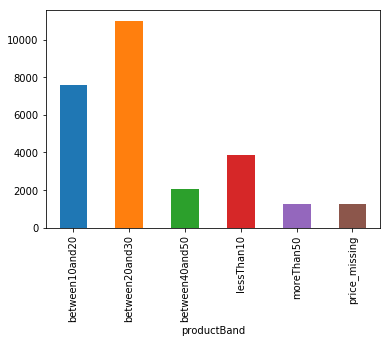

In [5]:
df.groupby(['productBand']).count()['date'].plot.bar()

Note: I realise that price_missing could be replaced, but I don't think it is necessary. It means that extra information is stored in the dataframe this way. Also the productBand column is redundant otherwise (as it can easily be reproduced with avg_price).

### Forecast workings
To start with I just plot the time-series of the data again, to help me think about how to takle the problem.

The first plot is of avg_price over time and the second plot is of total_products over time. This shows that the way avg_price has been imputed does not appear to follow the same trends seen in the last month, whereas total_products does seem to follow a similar sinisoidal peak/trough trend. So the total_products has probably been imputed quite well.

The first thing I want to try is to use the previous months trend and presume that similar behaviour will be seen for the rest of the current month. So I would like to remove the weekly trend from the data and just have the monthly trend to forecast with (the weekly trend can then be added later).

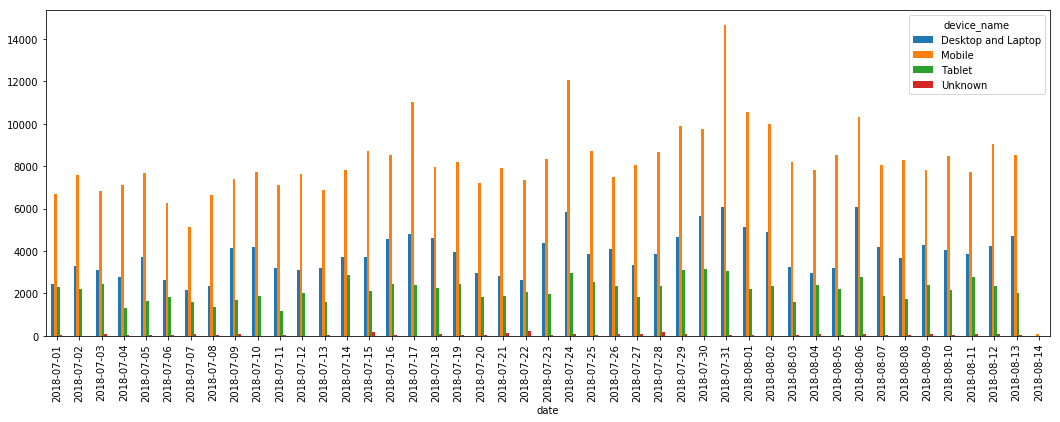

In [6]:
f, ax = plt.subplots(1,figsize=(18,6))
device_date=df.groupby(by=['device_name', 'date']).sum()
df.groupby(by=['device_name', 'date']).sum()['avg_price'].unstack(0).plot(kind='bar', ax=ax)

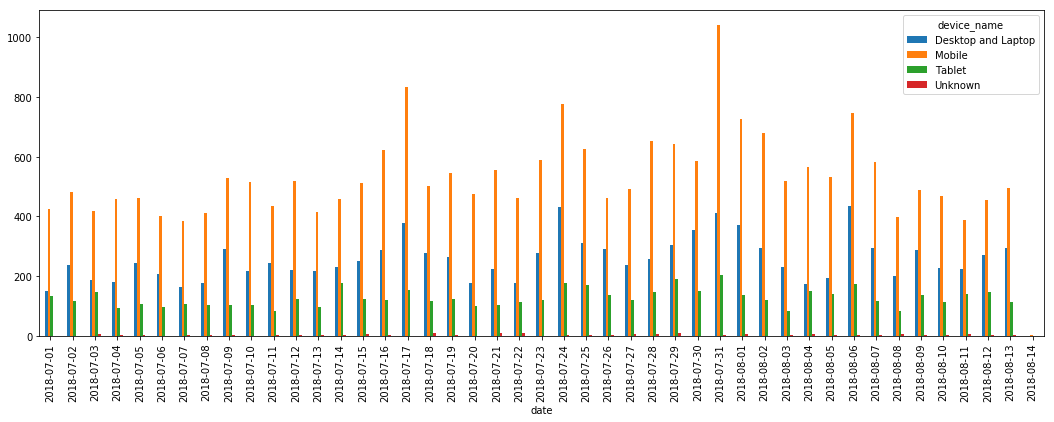

In [7]:
f, ax = plt.subplots(1,figsize=(18,6))

df.groupby(by=['device_name', 'date']).sum()['total_products'].unstack(0).plot(kind='bar', ax=ax)

Note: the two graphs above have very different trends for the last two weeks, because of the way the data was imputed. The total_products trend is more accurate

We only want to do short term forecasting, the best way to do that is to presume that there is a weekly and monthly trend that needs to be taken into account and forecast based on this. First want to find any weekly trend.

### Find Weekly Trend

This column can be used to remove the weekly trend by simply dividing by the expected number of sales on that day to normalise the sales for the week. Hopefully this will leave just the monthly trend.

In [8]:

df_e=df
df_e['weekday']=df['date'].apply(lambda x:pd.to_datetime(x).weekday())
device_weekday=df_e.groupby(by=['device_name', 'weekday']).sum()['total_products'].unstack(0)

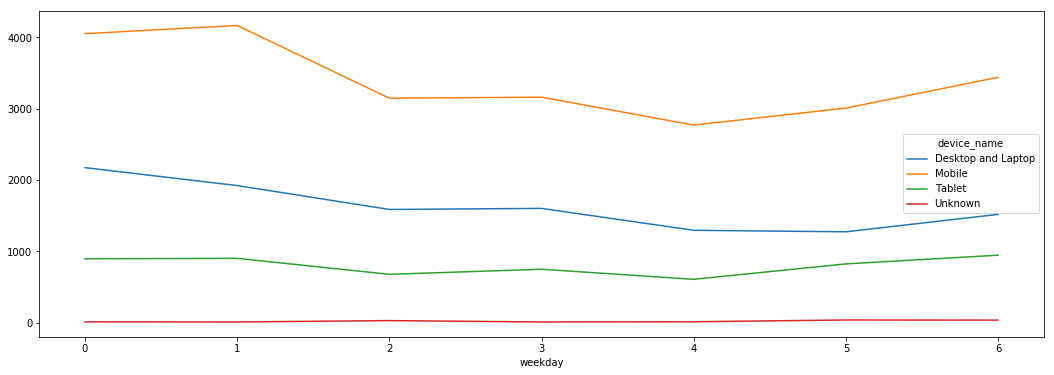

In [9]:
f, ax = plt.subplots(1,figsize=(18,6))
device_weekday.plot(ax=ax)

Remove this signal from the monthly data. Then find the monthly trend and combine them.

In [10]:
device_weekday['Desktop and Laptop']

weekday
0    2175.0
1    1924.0
2    1589.0
3    1604.0
4    1297.0
5    1276.0
6    1520.0
Name: Desktop and Laptop, dtype: float64

### Remove Weekly Trend

First I wanted to look at how many weeks were needed and mostly if there was going to be a problem with the weekday column.

In [11]:

df_e['week_of_year']=df['date'].apply(lambda x:pd.to_datetime(x).isocalendar()[1])
df_e.sort_values(['date','avg_hour'],ascending=[True,True])

,date,avg_hour,min_hour,max_hour,device_name,productBand,avg_price,total_products,num_orders,city,region,County,Country,weekday,week_of_year
4212,2018-07-01,0.0,0,0,Tablet,between20and30,29.950,1.0,1,Leeds,Leeds,missing_county,missing_country,6,26
4644,2018-07-01,0.0,0,0,Desktop and Laptop,between20and30,24.950,1.0,1,Oldham,Oldham,missing_county,missing_country,6,26
4946,2018-07-01,0.0,0,0,Tablet,between20and30,23.950,1.0,1,Neath,Neath Port Talbot,missing_county,missing_country,6,26
7077,2018-07-01,0.0,0,0,Desktop and Laptop,between20and30,22.950,1.0,1,Tower Hamlets,Tower Hamlets,missing_county,missing_country,6,26
11286,2018-07-01,0.0,0,0,Desktop and Laptop,between20and30,23.950,1.0,1,Oxford,Oxfordshire,Oxfordshire,England,6,26
11334,2018-07-01,0.0,0,0,Desktop and Laptop,lessThan10,3.490,1.0,1,Rotherham,Rotherham,missing_county,missing_country,6,26
11367,2018-07-01,0.0,0,0,Desktop and Laptop,between10and20,19.950,1.0,1,Rotherham,Rotherham,missing_county,missing_country,6,26
13272,2018-07-01,0.0,0,0,Desktop and Laptop,between10and20,15.900,1.0,1,Skelmersdale,Lancashire,Lancashire,England,6,26
13891,2018-07-01,0.0,0,0,Mobile,lessThan10,1.500,1.0,1,Wolverton,Milton Keynes,missing_county,missing_country,6,26
13906,2018-07-01,0.0,0,0,Desktop and Laptop,between10and20,17.500,1.0,1,Orpington,Bromley,missing_county,missing_country,6,26


In [12]:
df_e['week_of_year'].unique()

array([28, 31, 32, 27, 29, 33, 30, 26], dtype=int64)

Want a new dataframe, based on a groupby, but where only the total_products are summed and nothing else is, do this with .agg() and a dictionary. This is the dataframe that will be used for forecasting.

In [13]:
device_date=df.groupby(by=['device_name','date','weekday','week_of_year']).agg({'total_products': np.sum})
device_date.reset_index(inplace=True)#level=['weekday','week_of_year']);


Create a function that dived the total_products for that day by the expected for each day of the week, depending on which day of the week it currently is.

In [26]:
def scale_total_products(row,dwd):
    scaler=device_weekday[row['device_name']].apply(lambda x:x/device_weekday[row['device_name']].mean())
    weekday_temp=row['weekday']
    return row['total_products']/scaler[weekday_temp]

device_date['tp_scaled']=device_date.apply(lambda row:scale_total_products(row,device_weekday),axis=1)

Check the new dataframe, the new tp_scaled column is the new total_products that have been scaled by weekday.

In [27]:
device_date.head(10)

,device_name,date,weekday,week_of_year,total_products,tp_scaled
0,Desktop and Laptop,2018-07-01,6,26,149.0,159.432801
1,Desktop and Laptop,2018-07-02,0,27,236.0,176.476847
2,Desktop and Laptop,2018-07-03,1,27,187.0,158.078037
3,Desktop and Laptop,2018-07-04,2,27,182.0,186.286973
4,Desktop and Laptop,2018-07-05,3,27,244.0,247.411828
5,Desktop and Laptop,2018-07-06,4,27,206.0,258.322502
6,Desktop and Laptop,2018-07-07,5,27,164.0,209.039409
7,Desktop and Laptop,2018-07-08,6,27,176.0,188.323308
8,Desktop and Laptop,2018-07-09,0,28,291.0,217.604926
9,Desktop and Laptop,2018-07-10,1,28,219.0,185.128824


Can have a look a the difference between these columns below, seems as though the large spikes have been dampened a bit.

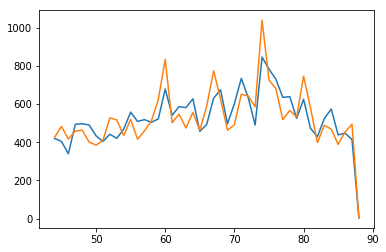

In [29]:
device_date[device_date['device_name']=='Mobile']['tp_scaled'].plot()
device_date[device_date['device_name']=='Mobile']['total_products'].plot()

#### Better method of removing weekly trends
Use unstacked groupby instead of an agg groupby, this is easier to handle and produces nicer graphs, the overall results is the same as above though.

In [89]:
modelling_df=df.groupby(by=['device_name', 'date']).sum()['total_products'].unstack(0)

In [90]:
modelling_df.head(10)

device_name,Desktop and Laptop,Mobile,Tablet,Unknown
date,,,,
2018-07-01,149.0,426.0,134.0,1.0
2018-07-02,236.0,483.0,116.0,NaN
2018-07-03,187.0,417.0,147.0,5.0
2018-07-04,182.0,459.0,92.0,2.0
2018-07-05,244.0,463.0,108.0,2.0
2018-07-06,206.0,401.0,96.0,1.0
2018-07-07,164.0,385.0,106.0,4.0
2018-07-08,176.0,410.0,103.0,3.0
2018-07-09,291.0,528.0,102.0,2.0


In [91]:
modelling_df.columns

Index(['Desktop and Laptop', 'Mobile', 'Tablet', 'Unknown'], dtype='object', name='device_name')

Apply the same function as above to this groupby, but with a small edit so that the different columns get looped through.

In [92]:
modelling_df=df.groupby(by=['device_name', 'date']).sum()['total_products'].unstack(0)
def scale_total_products_modelling(row,dwd,col):
    scaler=dwd[col].apply(lambda x:x/dwd[col].mean())
    weekday_temp=pd.to_datetime(row.name).weekday()
    #print(scaler,weekday_temp,scaler[weekday_temp])
    return row[col]/scaler[weekday_temp]
modelling_df_new=modelling_df
for column in modelling_df.columns:
    modelling_df_new[column]=modelling_df.apply(lambda row:scale_total_products_modelling(row,device_weekday,column),axis=1)

In [93]:
modelling_df_new.head(10)

device_name,Desktop and Laptop,Mobile,Tablet,Unknown
date,,,,
2018-07-01,159.432801,420.145971,113.423448,0.605263
2018-07-02,176.476847,404.432272,103.654470,NaN
2018-07-03,158.078037,339.534275,130.483407,9.583333
2018-07-04,186.286973,494.669691,108.563866,1.483871
2018-07-05,247.411828,496.771962,115.395853,3.833333
2018-07-06,258.322502,490.937745,126.283841,1.533333
2018-07-07,209.039409,434.079734,102.975095,2.300000
2018-07-08,188.323308,404.365840,87.183695,1.815789
2018-07-09,217.604926,442.112298,91.144448,3.538462


Can make a much nicer plot of the sales. The weekly trend has now been removed, so we just need to seperate the last two weeks from the dataframe and match the first two weeks of July to the first two weeks of August, then assume that the monthly trend for July will continue in August.

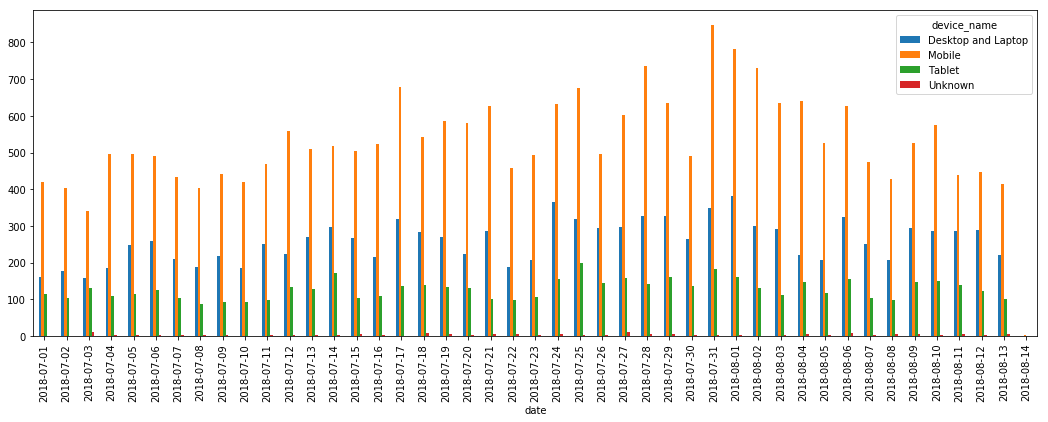

In [94]:
f, ax = plt.subplots(1,figsize=(18,6))
modelling_df_new.plot(kind='bar', ax=ax)

Now we can model the sales for the month, with weekly trends removed. Then combine the two later. Given more time, these could be fit simulatneously, but it's better to start with the basics.

### Create Forecasting Model

Do some basic data checks to see that all the dates are in the current dataframe

In [95]:
modelling_df_new.index

Index(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
       '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
       '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15',
       '2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
       '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25',
       '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
       '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04',
       '2018-08-05', '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
       '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13', '2018-08-14'],
      dtype='object', name='date')

In [96]:
modelling_df_new.shape

(45, 4)

Remove August from the dataframe

In [97]:
modelling_month=modelling_df_new[pd.to_datetime(modelling_df_new.index).month<8]
modelling_month.shape

(31, 4)

In [98]:
modelling_month

device_name,Desktop and Laptop,Mobile,Tablet,Unknown
date,,,,
2018-07-01,159.432801,420.145971,113.423448,0.605263
2018-07-02,176.476847,404.432272,103.654470,NaN
2018-07-03,158.078037,339.534275,130.483407,9.583333
2018-07-04,186.286973,494.669691,108.563866,1.483871
2018-07-05,247.411828,496.771962,115.395853,3.833333
2018-07-06,258.322502,490.937745,126.283841,1.533333
2018-07-07,209.039409,434.079734,102.975095,2.300000
2018-07-08,188.323308,404.365840,87.183695,1.815789
2018-07-09,217.604926,442.112298,91.144448,3.538462


So this is now the total_products for July, with the weekly trend removed.

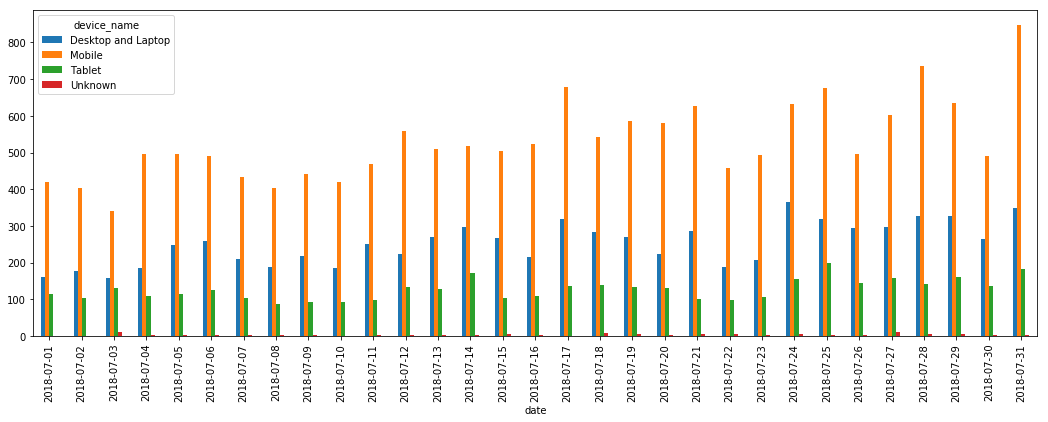

In [99]:
f, ax = plt.subplots(1,figsize=(18,6))
modelling_month.plot(kind='bar', ax=ax)

Can use this as a very simplistic model

In [100]:
modelling_month.reset_index(inplace=True)

It's a bit pointless having Unknown in, so dropping it. Also creating a new column so that the days of the month can be matched.

In [101]:
modelling_month['day_of_month']=modelling_month['date'].apply(lambda x:pd.to_datetime(x).day)
modelling_month.drop(['Unknown'],axis=1,inplace=True)

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
modelling_month

device_name,date,Desktop and Laptop,Mobile,Tablet,day_of_month
0,2018-07-01,159.432801,420.145971,113.423448,1
1,2018-07-02,176.476847,404.432272,103.654470,2
2,2018-07-03,158.078037,339.534275,130.483407,3
3,2018-07-04,186.286973,494.669691,108.563866,4
4,2018-07-05,247.411828,496.771962,115.395853,5
5,2018-07-06,258.322502,490.937745,126.283841,6
6,2018-07-07,209.039409,434.079734,102.975095,7
7,2018-07-08,188.323308,404.365840,87.183695,8
8,2018-07-09,217.604926,442.112298,91.144448,9
9,2018-07-10,185.128824,420.957362,93.202434,10


Create a new dataframe with just the August data

In [103]:
real_august=modelling_df_new[pd.to_datetime(modelling_df_new.index).month==8]
real_august=real_august[pd.to_datetime(real_august.index).day<13]
real_august#not sure if last two days have all the data, so use up to the 12th

device_name,Desktop and Laptop,Mobile,Tablet,Unknown
date,,,,
2018-08-01,381.785939,783.496439,160.485714,3.709677
2018-08-02,300.138938,730.673231,129.286095,NaN
2018-08-03,290.926313,635.403216,111.813817,3.066667
2018-08-04,220.511084,639.281063,145.719474,4.025000
2018-08-05,206.513628,525.675593,117.655666,2.421053
2018-08-06,325.285714,625.488421,156.375278,7.076923
2018-08-07,250.219780,473.068138,104.741783,3.833333
2018-08-08,205.734514,428.929275,99.123529,5.935484
2018-08-09,293.041058,524.668443,146.381777,5.750000


Now want a dataframe to match with the august data, using just the first two weeks of July. I've actually only used the first 12 days, as the sales on the last day (day 14) didn't seem to carry on throughout the day, and I figure I would be safe and also exclude the previous day (day 13) from the dataset.

In [104]:
matching_august=modelling_month[modelling_month['day_of_month']<13]
matching_august

device_name,date,Desktop and Laptop,Mobile,Tablet,day_of_month
0,2018-07-01,159.432801,420.145971,113.423448,1
1,2018-07-02,176.476847,404.432272,103.654470,2
2,2018-07-03,158.078037,339.534275,130.483407,3
3,2018-07-04,186.286973,494.669691,108.563866,4
4,2018-07-05,247.411828,496.771962,115.395853,5
5,2018-07-06,258.322502,490.937745,126.283841,6
6,2018-07-07,209.039409,434.079734,102.975095,7
7,2018-07-08,188.323308,404.365840,87.183695,8
8,2018-07-09,217.604926,442.112298,91.144448,9
9,2018-07-10,185.128824,420.957362,93.202434,10


Fit the two weeks to each other as a basic forecast. essentially I am using the previous month trend and presuming that the purchases will act in the exact same way (as opposed to some continued decrease).

### Data Matching
I use a simple linear least-square fitting process to work out the difference between the two two-week intervals of July and August. I've done this for two different devices 'Desktop and Laptop' and 'Mobile' to see if there is a noticeable difference.

In [105]:
#Try with Mobile first
y=matching_august['Mobile'].values
x1=real_august['Mobile'].values
o0=[1.]
errfunc = lambda o, x1, y: x1*o - y # Distance to the target function, through linear combination.
o1, success = opt.leastsq(errfunc, o0[:], args=(x1, y))
print(o1,success)

[0.75192871] 3


In [106]:
y=matching_august['Desktop and Laptop'].values
x1=real_august['Desktop and Laptop'].values
o0=[1.]
errfunc = lambda o, x1, y: x1*o - y # Distance to the target function, through linear combination.
o1, success = opt.leastsq(errfunc, o0[:], args=(x1, y))
print(o1,success)

[0.71127525] 3


Now that the data is fitted, we can just add one month to the July data and apply the scaling factor calculated above.

In [107]:
forecast_august=modelling_month
import datetime
def add_one_month(orig_date):
    # advance year and month by one month
    year = orig_date.year
    month = orig_date.month + 1
    day = orig_date.day
    return datetime.date(year, month, day)
forecast_august['date']=forecast_august['date'].apply(lambda x:add_one_month(pd.to_datetime(x)))
forecast_august

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


device_name,date,Desktop and Laptop,Mobile,Tablet,day_of_month
0,2018-08-01,159.432801,420.145971,113.423448,1
1,2018-08-02,176.476847,404.432272,103.654470,2
2,2018-08-03,158.078037,339.534275,130.483407,3
3,2018-08-04,186.286973,494.669691,108.563866,4
4,2018-08-05,247.411828,496.771962,115.395853,5
5,2018-08-06,258.322502,490.937745,126.283841,6
6,2018-08-07,209.039409,434.079734,102.975095,7
7,2018-08-08,188.323308,404.365840,87.183695,8
8,2018-08-09,217.604926,442.112298,91.144448,9
9,2018-08-10,185.128824,420.957362,93.202434,10


Set the index as the date now that the month has been modelled, also drop 'tablet' because unnecessary

In [108]:
forecast_august.set_index('date',inplace=True)

In [109]:
forecast_august.drop(['day_of_month','Tablet'],axis=1,inplace=True)

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Apply scaling factors calculated above

In [111]:
mobile_scaler=0.75192871
DandL_scaler=0.71127525
forecast_august['Desktop and Laptop']=forecast_august['Desktop and Laptop'].apply(lambda x:x*DandL_scaler)
forecast_august['Mobile']=forecast_august['Mobile'].apply(lambda x:x*mobile_scaler)
forecast_august

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


device_name,Desktop and Laptop,Mobile
date,,
2018-08-01,113.400605,315.919818
2018-08-02,125.523614,304.104237
2018-08-03,112.436995,255.305569
2018-08-04,132.501313,371.956343
2018-08-05,175.977910,373.537100
2018-08-06,183.738403,369.150185
2018-08-07,148.684558,326.397015
2018-08-08,133.949708,304.054285
2018-08-09,154.776998,332.436930


### Look Forecasted Sales

A moving average function is created, this is useful for plots to see what is going on.

In [113]:
def movingaverage(interval, window_size):
    """ 
    A function to calculate a moving average, useful for looking at data trends and for dampening noise in a less artificial way.
    """
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

create moving averages of the new forecast sales

In [114]:
move_av_mobile=movingaverage(forecast_august['Mobile'].values,4)
move_av_DandL=movingaverage(forecast_august['Desktop and Laptop'].values,4)
print(len(move_av_mobile))

31


Can now plot the sales forecast for the next two weeks, the only thing we are really missing now is the sales of the new product line. However we do have a good process now for forecasting sales and I will work on the second one after I have looked at estimating sales of the new line first.

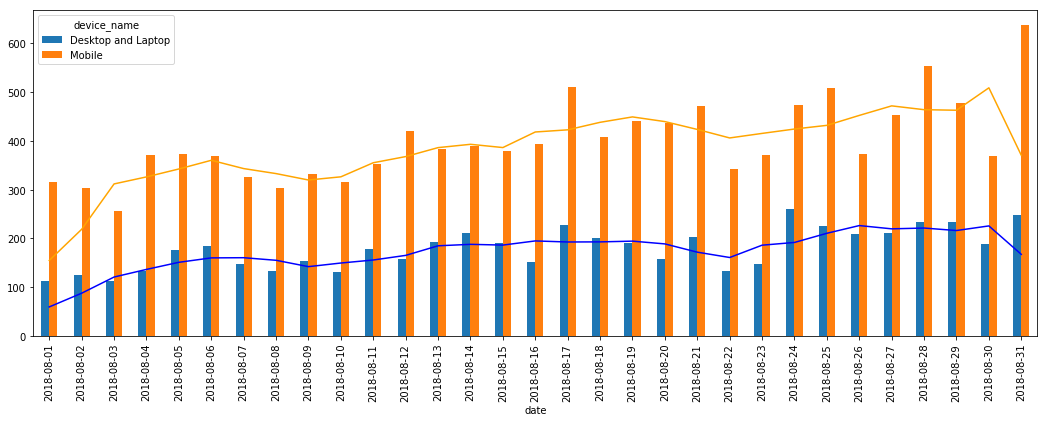

In [115]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august.plot(kind='bar', ax=ax)
ax.plot(move_av_mobile,color='orange')
ax.plot(move_av_DandL,color='blue')

This is a very simple way of forecasting sale. The reason why you should really do it this way though is that you cannot model monthly trends with only one months worth of data. So the only forecasting you can do is a monthly forecast, which presumes that the same behaviour is seen month to month. We can try in a bit to forecast without this assumption, but the results are less reliable. For now, I will use the function created in Estimating_Sales_for_Missing_Band to find the sales for the new product line. This will all be based on work in this notebook and the notebook Estimating_Sales_for_Missing_Band.